## What is the most optimal skill to learn for Data Analyst?

In [8]:
# Importing the necessary libraries
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast

# Loading dataset from Hugging Face and converting to a pandas DataFrame
dataset = load_dataset("lukebarousse/data_jobs")
df = dataset['train'].to_pandas()

# Converting the 'job_posted_date' column to datetime format
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])

# Converting 'job_skills' from stringified lists to actual Python lists
df['job_skills'] = df['job_skills'].apply(
    lambda x: ast.literal_eval(x) if pd.notna(x) else x
)

In [9]:
# Set the target country to filter job data
v_job_country = 'India'

# Set the job title you want to analyze
v_job_title = 'Data Analyst'

# Set the number of top skills to include in the skill percentage analysis
v_skill_perc = 10

In [10]:
# Filter the dataset for the selected country and job title
df_DA_Ind = df[(df['job_country'] == v_job_country) & (df['job_title_short'] == v_job_title)].copy()

# Remove rows where salary information is missing
df_DA_Ind_cleaned = df_DA_Ind.dropna(subset=['salary_year_avg'])

# Break the list of skills into individual rows so each skill is on its own row
df_DA_Ind_explode = df_DA_Ind_cleaned.explode('job_skills')

In [11]:
# Group the data by each skill and calculate:
# - how many times the skill appears (skill_count)
# - the median salary for that skill (median_salary)
df_DA_Ind_group = df_DA_Ind_explode.groupby('job_skills').agg(
    skill_count = ('job_skills', 'count'),
    median_salary = ('salary_year_avg', 'median')
).sort_values(by='skill_count', ascending=False)  # Sort skills by how often they appear

# Get the total number of job postings after cleaning
DA_job_totals = len(df_DA_Ind_cleaned)

# Calculate the percentage of job postings that mention each skill
df_DA_Ind_group['skill_perc'] = 100 * (df_DA_Ind_group['skill_count'] / DA_job_totals)

In [12]:
# Make a copy of the 'job_type_skills' column
df_technology = df['job_type_skills'].copy()

# Remove duplicate rows (if any)
df_technology = df_technology.drop_duplicates()

# Remove any missing (NaN) values
df_technology = df_technology.dropna()

# Create an empty dictionary to store combined technology data
technology_dict = {}

# Loop through each row in the column
for row in df_technology:
    # Convert the string in the row to a Python dictionary
    row_dict = ast.literal_eval(row)

    # Loop through each key-value pair in the dictionary
    for key, value in row_dict.items():
        # If the key already exists, add the values to the list
        if key in technology_dict:
            technology_dict[key] += value
        else:
            # If the key is new, create a new list
            technology_dict[key] = value

# Remove duplicates from each list of technologies
for key, value in technology_dict.items():
    technology_dict[key] = list(set(value))

In [13]:
# Convert the dictionary into a DataFrame with two columns: 'technology' and 'Skills'
df_technology = pd.DataFrame(list(technology_dict.items()), columns=['technology', 'Skills'])

# Break the list of skills in the 'Skills' column into individual rows (one skill per row)
df_technology_explode = df_technology.explode('Skills')

# Merge the DataFrame that has skill percentages and salary with the technology categories
# This helps us know which skill belongs to which broader technology
df_DA_skill_perc = df_DA_Ind_group.merge(
    df_technology_explode,
    left_on='job_skills',
    right_on='Skills',
    how='left'  # Keep all skills, even if not mapped to a technology
)

# Keep only the rows where the skill is required in at least v_skill_perc percent of job listings
df_DA_skill_perc = df_DA_skill_perc[df_DA_skill_perc['skill_perc'] >= v_skill_perc]

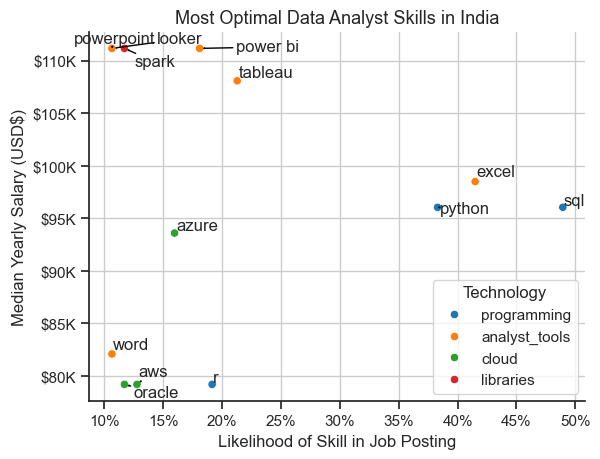

In [14]:
from matplotlib.ticker import PercentFormatter
from adjustText import adjust_text

# Set a clean and minimal style for the plot
sns.set_theme(style='ticks')

# Create a scatter plot:
# - x-axis: how common each skill is (percentage of job posts)
# - y-axis: median salary for jobs needing that skill
# - hue: color based on the broader technology category (like BI, databases, etc.)
sns.scatterplot(
    data=df_DA_skill_perc,
    x='skill_perc',
    y='median_salary',
    hue='technology',
    palette='tab10'  # Use a colorful palette for distinct categories
)

# Add legend to explain colors
plt.legend(title='Technology', loc='lower right')

# Label each point with its skill name
texts = []
for i, txt in enumerate(df_DA_skill_perc['Skills']):
    texts.append(
        plt.text(
            df_DA_skill_perc['skill_perc'].iloc[i],
            df_DA_skill_perc['median_salary'].iloc[i],
            txt
        )
    )

# Adjust text labels so they don't overlap and draw arrows to points
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black', lw=1))

# Format x-axis as percentage (e.g., 25 instead of 0.25)
ax = plt.gca()
ax.xaxis.set_major_formatter(PercentFormatter(decimals=0))

# Format y-axis to show salary in "$000K" format
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f"${int(y/1000)}K"))

# Add plot title and labels
plt.title(f"Most Optimal {v_job_title} Skills in {v_job_country}", fontsize=13)
plt.xlabel('Likelihood of Skill in Job Posting')
plt.ylabel('Median Yearly Salary (USD$)')

# Add gridlines for easier reading and remove top/right borders
plt.grid()
sns.despine()

# Show the final plot
plt.show()